Сделать venv

In [5]:
%pip install ngsolve
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install openpyxl

In [1]:
from ngsolve import *
from netgen.csg import *
from netgen.geom2d import SplineGeometry
import numpy as np
import matplotlib.pyplot as plt
from netgen.webgui import Draw as DrawGeo
import pandas as pd

In [13]:
import netgen.gui
%gui tk

$$C{\left(x\right)\rho\left(x\right)\frac{\partial u}{\partial t}\left(x,t\right)-}\mathrm{\nabla}\bullet\left[k\left(x\right)\bullet\mathrm{\nabla u}\left(x,t\right)\right]=f\left(x,t\right)$$
При переходе из м^3 в мм^3 x’ = 1000x
$$\frac{\partial u}{\partial x^\prime}\left(x^\prime,t\right)=\frac{\partial u}{\partial x}\left(x,t\right)\ast\frac{dx}{dx^\prime}={10}^{-3}\frac{\partial u}{\partial x}\left(x,t\right)$$
$$\frac{\partial^2u}{\partial{x^\prime}^2}\left(x^\prime,t\right)=\frac{\partial}{\partial x}(\frac{\partial u}{\partial x'})\ast\frac{dx}{dx^\prime}={10}^{-6}\frac{\partial u}{\partial x}\left(x,t\right)$$
тогда:
$$C{\left(x\right)\rho\left(x\right)\frac{\partial u}{\partial t}\left(x,t\right)-}{10}^6\mathrm{\nabla}\bullet\left[k\left(x\right)\bullet\mathrm{\nabla u}\left(x,t\right)\right]=f\left(x,t\right)$$

In [2]:
def create_geometry():
    # Создание сфер с разными радиусами
    scalp = Sphere(Pnt(0, 0, 0), 98.0).mat("scalp").bc("scalp")
    skull = Sphere(Pnt(0, 0, 0), 93.0).mat("skull").bc("skull")
    csf = Sphere(Pnt(0, 0, 0), 88.0).mat("csf").bc("csf")
    surface_brain = Sphere(Pnt(0, 0, 0), 86.0).mat("surface_brain").bc("surface_brain")
    deep_brain = Sphere(Pnt(0, 0, 0), 69.0).mat("deep_brain").bc("deep_brain")

    # Вычитание сфер для создания вложенных структур
    geo = CSGeometry()
    geo.Add(scalp - skull)
    geo.Add(skull - csf)
    geo.Add(csf - surface_brain)
    geo.Add(surface_brain - deep_brain)
    geo.Add(deep_brain)
    
    # Генерация сетки
    ngmesh = geo.GenerateMesh(maxh=15)
    
    # Экспорт сетки в файл формата Gmsh
    ngmesh.Export("export-3d.msh", "Gmsh Format")

    # Преобразование сетки в формат NGSolve
    return Mesh(ngmesh)

# Создание и визуализация геометрии
mesh = create_geometry()
Draw(mesh)
Redraw()

True

In [3]:
print(mesh.GetBoundaries())
print(mesh.GetMaterials())

('scalp', 'skull', 'csf', 'surface_brain', 'deep_brain')
('scalp', 'skull', 'csf', 'surface_brain', 'deep_brain')


In [4]:
T0 = Parameter(10.0)  # ambient temperature
h = 6*10**-3  # Heat transfer coefficient (W/m²K)
region_densities = np.array([1000, 1500, 1003, 1050, 1050])/10**6  # density [kg/m^3]
p = CoefficientFunction(list(region_densities))
region_hcs = np.array([4000, 2300, 4174, 3700, 3700])  # specific heat capacity [J/K kg]
C = CoefficientFunction(list(region_hcs))
# Define range of thermal conductivities in the regions [W/m/k]
region_conductivities = np.array([0.34, 1.16, 0.618, 0.503, 0.503])
k = CoefficientFunction(list(region_conductivities))
k_test = CoefficientFunction(list(np.array([0.1, 0.1, 0.1, 0.1])))  # thermal conductivitie at the boundary
# Define range of specific heat capacities in the regions
region_losses = np.array([0, 0, 0, 0, 0])

# Initial value of solution
initial_value = 37.2  # [°C]

In [5]:
# H1-conforming finite element space
fes = H1(mesh, order=3, dirichlet="scalp|skull|csf|surface_brain|deep_brain")

# define trial- and test-functions
u = fes.TrialFunction()
v = fes.TestFunction()

# Solving the Poisson equation
f = LinearForm(fes)
f.Assemble()

a = BilinearForm(k * grad(u) * grad(v) * dx).Assemble()

gfu = GridFunction(fes)


In [6]:
gfuDir = GridFunction(fes)
gfuDir.Set(37.2, definedon=mesh.Boundaries("deep_brain"))
gfu.vec.data += gfuDir.vec

gfuDir = GridFunction(fes)
gfuDir.Set(35.5, definedon=mesh.Boundaries("surface_brain"))
gfu.vec.data += gfuDir.vec

gfuDir = GridFunction(fes)
gfuDir.Set(35, definedon=mesh.Boundaries("csf"))
gfu.vec.data += gfuDir.vec

gfuDir = GridFunction(fes)
gfuDir.Set(34, definedon=mesh.Boundaries("skull"))
gfu.vec.data += gfuDir.vec

gfuDir = GridFunction(fes)
gfuDir.Set(CoefficientFunction(31), definedon=mesh.Boundaries("scalp"))
gfu.vec.data += gfuDir.vec
Draw(gfu)

### для отладки

In [9]:
gfuDir = GridFunction(fes)
gfuDir.Set(37.2, definedon=mesh.Boundaries("deep_brain"))
gfu.vec.data += gfuDir.vec
Draw(gfu)

In [140]:
gfuDir = GridFunction(fes)
gfuDir.Set(35.5, definedon=mesh.Boundaries("surface_brain"))
gfu.vec.data += gfuDir.vec
Draw(gfu)


In [141]:
gfuDir = GridFunction(fes)
gfuDir.Set(35, definedon=mesh.Boundaries("csf"))
gfu.vec.data += gfuDir.vec
Draw(gfu)

In [142]:

gfuDir = GridFunction(fes)
gfuDir.Set(34, definedon=mesh.Boundaries("skull"))
gfu.vec.data += gfuDir.vec
Draw(gfu)


In [149]:
gfuDir = GridFunction(fes)
gfuDir.Set(CoefficientFunction(31), definedon=mesh.Boundaries("sсalp"))
gfu.vec.data += gfuDir.vec
Draw(gfu)

In [151]:
# Poisson dirichlet boundary conditions
gfu.Set(31, definedon=mesh.Boundaries("scalp"))
Draw(gfu)

In [130]:
gfu.Set(34, definedon=mesh.Boundaries("skull"))
Draw(gfu)

In [131]:
gfu.Set(35, definedon=mesh.Boundaries("csf"))
Draw(gfu)

In [132]:
gfu.Set(35.5, definedon=mesh.Boundaries("surface_brain"))
Draw(gfu)

In [133]:
gfu.Set(35.5, definedon=mesh.Boundaries("deep_brain"))
Draw(gfu)

### решение пуассона

In [7]:
r = f.vec.CreateVector()
r.data = f.vec - a.mat * gfu.vec
gfu.vec.data += a.mat.Inverse(freedofs=fes.FreeDofs()) * r

Draw(gfu)
Redraw()

True

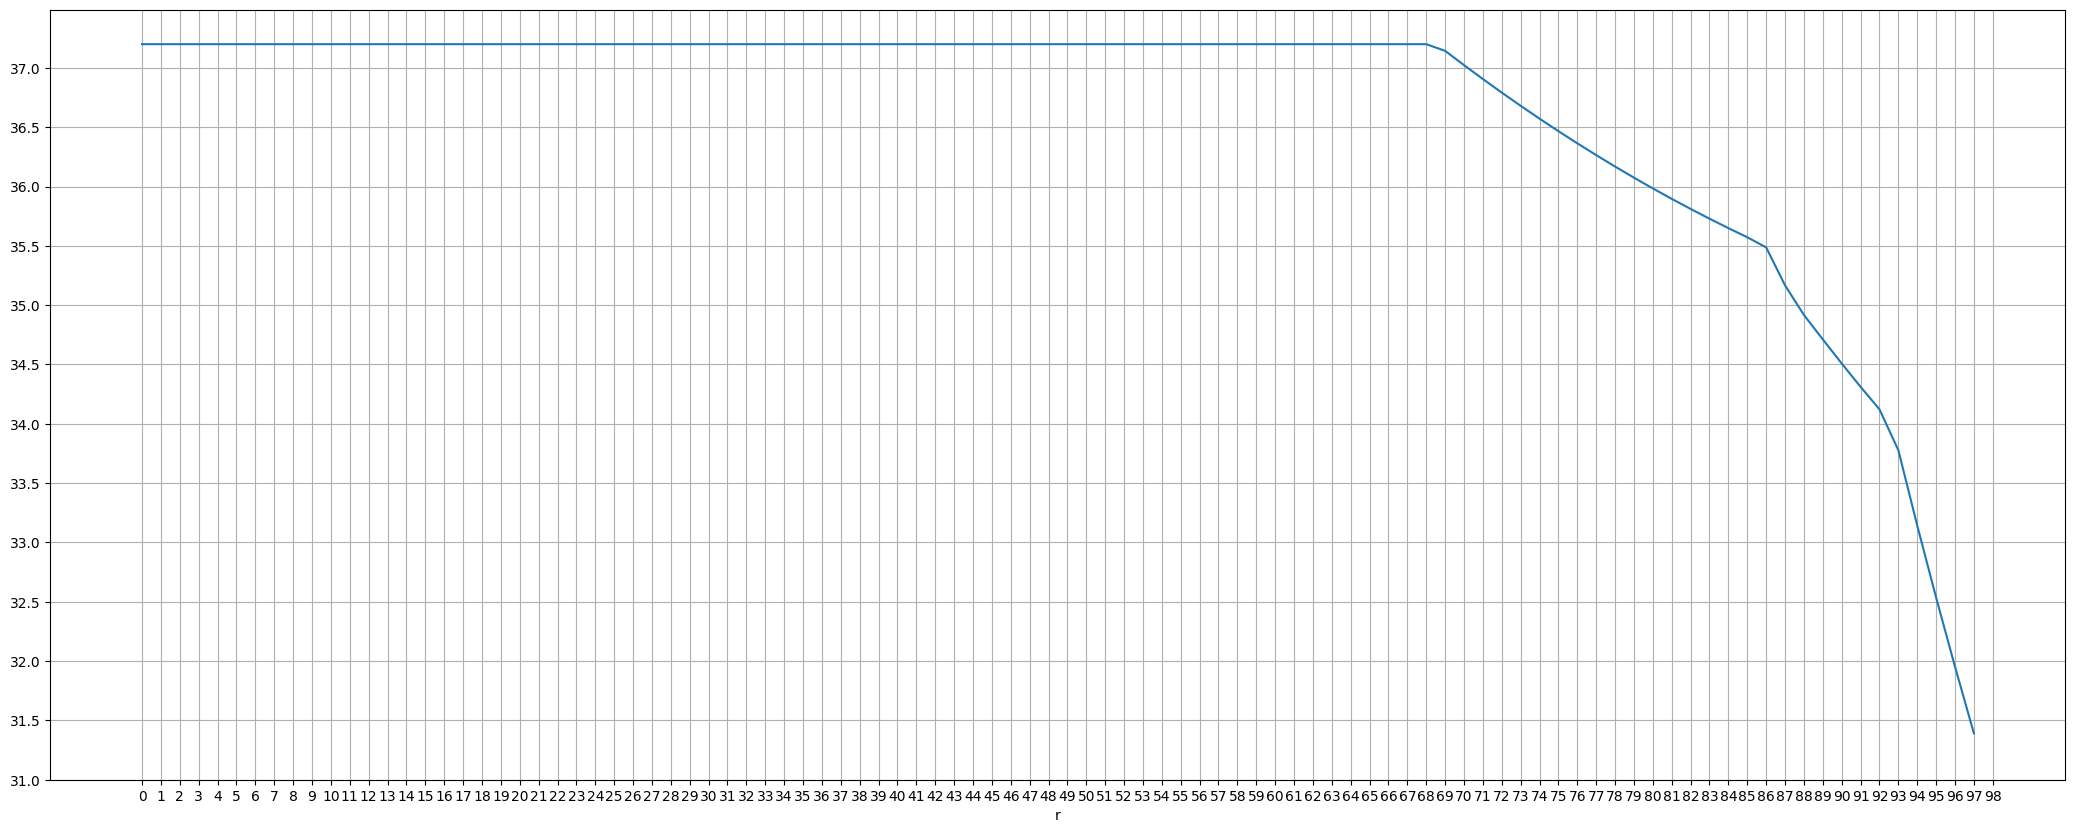

In [8]:
pts = []
vals = []

for r in range(0, 98):
    mip = mesh(r, 0, 0)
    pts.append(r)
    vals.append(gfu(mip))


plt.plot(pts, vals)
plt.xlabel('r')
plt.xticks(np.arange(0, (len(pts)+1), 1))
plt.yticks(np.arange(31, 37.2, 0.5))
plt.gcf().set_size_inches(26, 10)

#plt.yticks(np.arange(0, 37.5, 1))
#plt.xticks(np.arange(0, 1, 20))
plt.grid(True)
plt.show()

### Решение нестационарной задачи теплопроводности

In [9]:
# Solving a non-stationary problem, use Poisson equation solution as initial conditions
fes = H1(mesh, order=3)

u = fes.TrialFunction()  # symbolic object
v = fes.TestFunction()  # symbolic object

a = BilinearForm(k * grad(u) * grad(v) * dx)

a += h * u * v * ds(definedon=mesh.Boundaries('scalp'))
a.Assemble()

m = BilinearForm(fes, symmetric=False)
m += SymbolicBFI(C * p * u * v)
m.Assemble()

f = LinearForm(fes)
f += h * T0 * v * ds(definedon=mesh.Boundaries('scalp'))
f.Assemble()

dt = 60
t_end = 60 * 60 * 25
sources = 1
t = 0.0
snapshots = []

mstar = m.mat.CreateMatrix()
mstar.AsVector().data = m.mat.AsVector() + dt * a.mat.AsVector()
invmstar = mstar.Inverse(freedofs=fes.FreeDofs(), inverse="sparsecholesky")
res = gfu.vec.CreateVector()

mip = mesh(0, 0, 0)

Draw(gfu)
res = gfu.vec.CreateVector()
pts = []
vals = []
surf_vals = []

for j in range(int(t_end / dt)):
    res.data = f.vec - a.mat * gfu.vec
    gfu.vec.data += dt * invmstar * res
    print(j, gfu(mip))
    pts.append(t / 60 / 60)
    vals.append(gfu(mip))
    surf_vals.append(gfu(mesh(97, 0)))
    Redraw()
    t = round(t + dt, 6)

solution_vector = gfu.vec.FV().NumPy()[:]
print(surf_vals)

0 37.19999839542704
1 37.199994969496224
2 37.19999851451604
3 37.20000169623102
4 37.20000433071129
5 37.200007877660255
6 37.20001246385441
7 37.20001675302065
8 37.20001834174121
9 37.20001385190094
10 37.19999874542652
11 37.199967051649416
12 37.19991112670837
13 37.19982148475196
14 37.19968670246268
15 37.19949338928865
16 37.19922621714243
17 37.19886800513924
18 37.19839985452328
19 37.19780132698732
20 37.19705065750205
21 37.19612499146184
22 37.19500063571685
23 37.19365331377048
24 37.19205841676457
25 37.190191243521745
26 37.18802722460943
27 37.18554212695864
28 37.18271223692558
29 37.179514520794605
30 37.17592676258934
31 37.171927679716184
32 37.16749701743721
33 37.16261562349634
34 37.15726550443103
35 37.15142986521918
36 37.145093133957985
37 37.138240973265525
38 37.13086028005115
39 37.12293917522743
40 37.11446698484339
41 37.105434214013165
42 37.09583251490128
43 37.08565464990924
44 37.074894451091986
45 37.063546776719804
46 37.0516074657925
47 37.0390732

1          0
2        600
3       1200
4       1800
5       2400
       ...  
141    84000
142    84600
143    85200
144    85800
145    86400
Name: Êîîðäèíàòû òî÷êè: x = 0; y = 0, Length: 145, dtype: int64


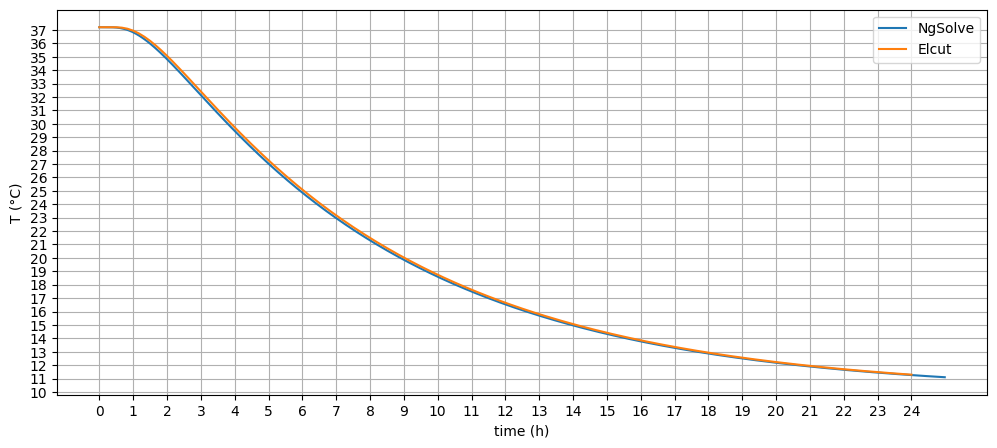

In [10]:
file_path = 'elcut_3d.xlsx'


sheet_name = '1'
columns_to_load = [0, 1]


df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_load)
df = df.drop(0)
df = df.apply(pd.to_numeric, errors='coerce')


print(df.iloc[:,0])
plt.plot(pts, vals, df.iloc[:,0]/60/60, df.iloc[:,1])
plt.xlabel('time (h)')
plt.ylabel('T (°C)')
plt.legend(['NgSolve', 'Elcut'])
plt.yticks(np.arange(10, 37.5, 1))
plt.xticks(np.arange(0, 25, 1))
plt.grid(True)
plt.gcf().set_size_inches(12, 5)
plt.show()

In [11]:
def brain(K):
  return 8.425 * K

def rectum(k, Ta):
  if Ta < 23.3:
      return 8 * k
  return 10 * k

Ta = 10
T0 = 37.2
k = 0.127

import math
def tmp(t, k):
  #p = brain(k)
  p = 1.07
  #return Ta + (T0-Ta) * math.exp(-k * t) + k / (k - p) * (T0 - Ta) * (math.exp(-p*t) - math.exp(-k*t))
  return Ta + (T0-Ta) * (p/(p - k)* math.exp(-k * t) + k / (k - p) * math.exp(-p*t))

pts1 = []
vals1 = []
for i in range(25*5+1):
    pts1.append(i/5)
    vals1.append(tmp(i/5, k))

1          0
2        600
3       1200
4       1800
5       2400
       ...  
141    84000
142    84600
143    85200
144    85800
145    86400
Name: Êîîðäèíàòû òî÷êè: x = 0; y = 0, Length: 145, dtype: int64


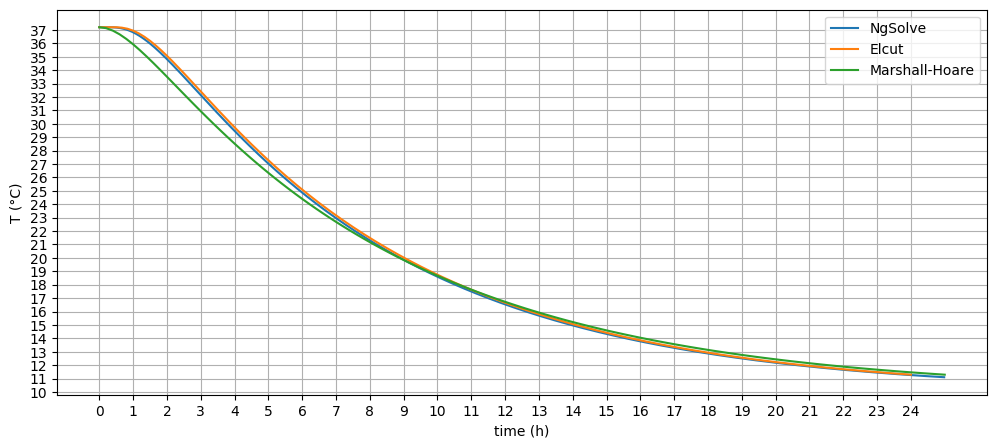

In [12]:
print(df.iloc[:,0])
plt.plot(pts, vals, df.iloc[:,0]/60/60, df.iloc[:,1], pts1, vals1)
plt.xlabel('time (h)')
plt.ylabel('T (°C)')
plt.legend(['NgSolve', 'Elcut', 'Marshall-Hoare'])
plt.yticks(np.arange(10, 37.5, 1))
plt.xticks(np.arange(0, 25, 1))
plt.grid(True)
plt.gcf().set_size_inches(12, 5)
plt.show()